# Introduction

## Objective

We have a dataset of Personal Key Indicators of Heart Disease (link : https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease). 
It comes from the 2020 annual CDC survey data of 400k adults related to their health status.

*About half of all Americans (47%) have at least 1 of 3 key risk factors for heart disease: high blood pressure, high cholesterol, and smoking. Detecting and preventing the factors that have the greatest impact on heart disease is very important in healthcare.*

Our goal is to **predict whether a patient has a heart disease** given his or her statement. 
Thus, we would like to **maximize the true positive** rate and capture as many potential diseased patients as possible. **Recall** for the minority class is thus the metric we would like to optimize.

*In the case of a mislabelled patient when the model predicts that he or she has a heart disease and that is not true, the worst thing that happens is to run unnecessary tests. It increases economical costs, but better safe than sorry, right ?*

## Structure of the notebook 

The notebook is structured as it follows: 
- Exploration Data Analysis (EDA), 
- Preprocessing steps including experiment on under/over-sampling or class weighting, 
- Machine Learning Models implementation, 
- Deepl Learning Model (Neural Network) implementation. 

## Common Libraries and Data

In [1]:
import pandas as pd 
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1CiSOFOMlqsDiBl-9R81OTMQTX9jDnZ0V'
downloaded = drive.CreateFile({'id': file_id})
#print('Downloaded content "{}"'.format(downloaded.GetContentString()))
downloaded.GetContentFile('heart_2020_cleaned.csv') 

In [50]:
df = pd.read_csv('heart_2020_cleaned.csv')
df.head()

HeartDisease    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
0           No  16.60     Yes              No     No             3.0   
1           No  20.34      No              No    Yes             0.0   
2           No  26.58     Yes              No     No            20.0   
3           No  24.21      No              No     No             0.0   
4           No  23.71      No              No     No            28.0   

   MentalHealth DiffWalking     Sex  AgeCategory   Race Diabetic  \
0          30.0          No  Female        55-59  White      Yes   
1           0.0          No  Female  80 or older  White       No   
2          30.0          No    Male        65-69  White      Yes   
3           0.0          No  Female        75-79  White       No   
4           0.0         Yes  Female        40-44  White       No   

  PhysicalActivity  GenHealth  SleepTime Asthma KidneyDisease SkinCancer  
0              Yes  Very good        5.0    Yes            No        Yes  
1              Yes  Very good        7.0     No            No         No  
2              Yes       Fair        8.0    Yes            No         No  
3               No       Good        6.0     No            No        Yes  
4              Yes  Very good        8.0     No            No         No

# EDA

In EDA, we will simply follows this methodology: 
1. Understanding the form of our data, 
2. Understanding the content. 

## Form Analysis

### Target 

In [ ]:
df.HeartDisease.value_counts()

No     292422
Yes     27373
Name: HeartDisease, dtype: int64

We clearly have a binary and umbalanced feature. 
We will thus have to tackle this umbalancement of classes. 

### Types of features

In [ ]:
df.dtypes.value_counts()

object     14
float64     4
dtype: int64

Out of 17 features, we have only 4 numerical ones, and 13 categorical ones. 

### Check the number of missing values

In [ ]:
(df.isna().sum()/df.shape[0]*100).sort_values(ascending = False)

HeartDisease        0.0
BMI                 0.0
KidneyDisease       0.0
Asthma              0.0
SleepTime           0.0
GenHealth           0.0
PhysicalActivity    0.0
Diabetic            0.0
Race                0.0
AgeCategory         0.0
Sex                 0.0
DiffWalking         0.0
MentalHealth        0.0
PhysicalHealth      0.0
Stroke              0.0
AlcoholDrinking     0.0
Smoking             0.0
SkinCancer          0.0
dtype: float64

We don't have any missing values.

### Duplicates

As we can guess looking to the various features, we might not have a lot of different instances for some columns. 
There might be duplicated rows. 

In [ ]:
print(f'Number of duplicated recrods = {df.duplicated().sum()}')

Number of duplicated recrods = 18078


We will drop them in the preprocessing stage. 

## Content Analysis

### Vizualisation of the target

We already know that the classes are umbalanced, so let's plot a pie to confirm it. 

In [ ]:
fig = px.pie(df.HeartDisease.value_counts(), values=df.HeartDisease.value_counts().values,names =df.HeartDisease.value_counts().index, title='Repartition of declaring heart disease')
fig.show()

Wouaw that's a wide majority of healthy people, great!
We can **already predict that the general accuracy will be high if we don't deal with this umbalancement of classes**, as a lot of predicted sample will be put into the most common class. 

### Categorical Features

Let's see if something comes out by simply plotting pie charts for categorical values. 

In [ ]:
for col in df.select_dtypes("object"):
  fig = px.pie(df[col].value_counts(), values=df[col].value_counts().values,names =df[col].value_counts().index, title=f'{col}')
  fig.show()

We have kind of an uniform distribution for sex and age. 

Nonetheless, what would be very intersting now, it so see to what extent each feature is discriminant for health disease. 

*For example, among smokers, what is the percentage of people with a disease?*


In [ ]:
for col in df.select_dtypes("object"): 
    print("\n")
    labels = df[col].value_counts().index

    try : #to avoid the case of HeartDisease (no group by )
        df_label_1 = df[df[col]==labels[0]].groupby('HeartDisease').count()[col]
        df_label_2 = df[df[col]==labels[1]].groupby('HeartDisease').count()[col]


        # Create subplots: use 'domain' type for Pie subplot
        fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
        fig.add_trace(go.Pie(labels = df_label_1.index, values=df_label_1.values ),
                      1, 1)
        fig.add_trace(go.Pie(labels =df_label_2.index, values=df_label_2.values),
                      1, 2)

        # Use `hole` to create a donut-like pie chart
        fig.update_traces(hole=.4, hoverinfo="label+percent+name")

        fig.update_layout(
            title_text=col,
            # Add annotations in the center of the donut pies.
            annotations=[dict(text=f'{col} = {labels[0]}', x=0.19, y=0.5, font_size=10, showarrow=False),
                         dict(text=f'{col} = {labels[1]}', x=0.84, y=0.5, font_size=10, showarrow=False)])
        fig.show()
    except : 
        continue

We can see that for every feature, the % of disease people for every instance is different. That means that each instance is discriminant for predict a Heart Disease. 

### Histogram of continuous variables

Let's see what the categorical variables have in store :

In [ ]:
df_positive = df[df.HeartDisease=="Yes"]
df_negative = df[df.HeartDisease=="No"]

for col in df.select_dtypes('float'): 
    x = df_positive[col]
    y = df_negative[col]

    fig = go.Figure()

    fig.add_trace(go.Histogram(x=x, name = "With Heart Disease"))
    fig.add_trace(go.Histogram(x=y, name = "Without Heart Disease"))

    # Overlay both histograms
    fig.update_layout(barmode='overlay',
    title_text=col, # title of plot
    xaxis_title_text='Value', # xaxis label
    yaxis_title_text='Count') # yaxis label
    # Reduce opacity to see both histograms
    fig.update_traces(opacity=0.55)
    fig.show()

We can see that every numerical features conveys important information. 

According to their distribution, we will use :  

1. Standard Scaler for BMI and SleepTime,
2. MinMax Scaler PhysicalHealth and MentalHealth. 

# Pre processing

Finally ! Let's compute according to the analysis of the EDA. 

We had some duplicated rows. 

In [ ]:
df = df.drop_duplicates()

### Encoding

For encosing: 
- Yes and No simply into 1 and 0 (we generalize putting extra cases of diabetes into No), 

In [ ]:
def encoding(df):
    data = df.copy()
    data = data.replace(["Yes"] , 1)
    data = data.replace(["No", "No, borderline diabetes","Yes (during pregnancy)"], 0)
    data = pd.get_dummies(data)

    return data

In [ ]:
df_encoded = encoding(df)
df_encoded.head()

HeartDisease    BMI  Smoking  AlcoholDrinking  Stroke  PhysicalHealth  \
0             0  16.60        1                0       0             3.0   
1             0  20.34        0                0       1             0.0   
2             0  26.58        1                0       0            20.0   
3             0  24.21        0                0       0             0.0   
4             0  23.71        0                0       0            28.0   

   MentalHealth  DiffWalking  Diabetic  PhysicalActivity  ...  Race_Asian  \
0          30.0            0         1                 1  ...           0   
1           0.0            0         0                 1  ...           0   
2          30.0            0         1                 1  ...           0   
3           0.0            0         0                 0  ...           0   
4           0.0            1         0                 1  ...           0   

   Race_Black  Race_Hispanic  Race_Other  Race_White  GenHealth_Excellent  \
0           0              0           0           1                    0   
1           0              0           0           1                    0   
2           0              0           0           1                    0   
3           0              0           0           1                    0   
4           0              0           0           1                    0   

   GenHealth_Fair  GenHealth_Good  GenHealth_Poor  GenHealth_Very good  
0               0               0               0                    1  
1               0               0               0                    1  
2               1               0               0                    0  
3               0               1               0                    0  
4               0               0               0                    1  

[5 rows x 40 columns]

## Splitting

Let's split our data before applying our scaling step. 
We want to avoid data leakage, as our test set needs to stay unseed by our model. 

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = df_encoded.drop(columns=['HeartDisease']) 
y = df_encoded['HeartDisease'] 

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify = y, random_state = 42)

We check if we have the same proportion between trainset and test set for the labels, which should be the case as we used stratify = y. 

In [ ]:
y_train.value_counts()/y_train.shape[0]*100

0    90.964607
1     9.035393
Name: HeartDisease, dtype: float64

In [ ]:
y_test.value_counts()/y_test.shape[0]*100

0    90.965133
1     9.034867
Name: HeartDisease, dtype: float64

## Scaler

Let's scale our 4 numerical features according to what has been seen during EDA. 

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

ss = StandardScaler()

minms = MinMaxScaler()

ct = ColumnTransformer(
    [('standard_scaler', ss, ['BMI', 'SleepTime']), 
     ('minmax_scaler', minms, ['MentalHealth', 'PhysicalHealth'])]
)

X_train_transformed = ct.fit_transform(X_train)
X_test_transformed = ct.transform(X_test)

X_train[['BMI', 'SleepTime','MentalHealth', 'PhysicalHealth']] = X_train_transformed
X_test[['BMI', 'SleepTime','MentalHealth', 'PhysicalHealth']] = X_test_transformed

In [ ]:
X_train.head()

BMI  Smoking  AlcoholDrinking  Stroke  PhysicalHealth  \
176113  0.474667        0                0       0        0.000000   
6984   -1.067100        0                0       0        0.000000   
207892  0.539616        1                0       0        0.466667   
260064 -0.600086        0                0       0        0.000000   
45725   1.359212        1                0       0        0.133333   

        MentalHealth  DiffWalking  Diabetic  PhysicalActivity  SleepTime  ...  \
176113           0.1            0         0                 1  -0.056883  ...   
6984             0.0            0         0                 1   0.625866  ...   
207892           0.0            0         0                 0   0.625866  ...   
260064           0.0            0         0                 0  -0.056883  ...   
45725            0.0            0         0                 1  -0.056883  ...   

        Race_Asian  Race_Black  Race_Hispanic  Race_Other  Race_White  \
176113           0           0              0           0           1   
6984             0           0              0           0           1   
207892           0           1              0           0           0   
260064           0           0              1           0           0   
45725            0           0              0           0           0   

        GenHealth_Excellent  GenHealth_Fair  GenHealth_Good  GenHealth_Poor  \
176113                    0               0               1               0   
6984                      0               0               0               0   
207892                    0               0               0               0   
260064                    0               1               0               0   
45725                     0               0               1               0   

        GenHealth_Very good  
176113                    0  
6984                      1  
207892                    1  
260064                    0  
45725                     0  

[5 rows x 39 columns]

## First simple Machine Learning Model 

The first simple steps of preprocessing being done, let's see how a simple RandomForestClassifier performs. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

In [ ]:
rfc = RandomForestClassifier(random_state = 0 )

We already know that the **general accuracy will be pretty high** because a lot of sample are predicted in the most common label (without a heart disease). We will have to tackle this underrepresented label, with **undersampling or class weighting** in some gradient descent models. 

For this project, we respect all hypothesis to use **AUC** as our objective metric : 
1. We have a binary classification problem, 
2. We have a umbalanced dataset. 

So let's define an evaluation function that, for each model: 
1. Fits the model, 
2. Prints the confusion matrix, 
3. Print the classification report, 
4. Draws the ROC curve if wanted, 
5. Draws the learning curve if wanted, to prevent over or underfitting. 

We will thus mainly focus on the recall score for the positive class, and f1 scores for both classes. 

*Why is there X_train, y_train, X_test,y_test in this function ?*

*Spoiler Alert : for the Deep Learning part, we will have to convert the types of thoses into tensors.*

In [ ]:
def auc_evaluation (model, X_train, y_train, X_test,y_test,draw_roc_curve = False,draw_learning_curve=False ): 

  #As drawing the roc curve can take some time, you have to explicitely mention it in the parameters. 
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  print("Confusion Matrix : ")
  print(confusion_matrix(y_test, y_pred))
  print('\n')

  print("Classification Report : ")
  print(classification_report(y_test, y_pred))

  if draw_roc_curve==True :

    model_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, model_probs)
    auc = roc_auc_score(y_test, model_probs)

    fig = plt.figure(figsize = (10,8))
    plt.plot(fpr, tpr, marker='*', label='(AUC = %0.3f)' % auc)
    plt.plot([0,1], [0,1], 'k--', label = 'Random Classifier')
    plt.title('ROC Plot')
    plt.xlabel('False Positive Rate ')
    plt.ylabel('True Positive Rate = sensitivity = recall')
    plt.legend()
    plt.show()

  if draw_learning_curve==True :

    N, train_score, val_score = learning_curve (model , X_train, y_train, cv = 3, scoring = "f1_macro", train_sizes = np.linspace(0.1, 1, 7)) #f1_macro gives an more objective measure on umbalanced datasets
    plt.figure (figsize = (10,8))
    plt.plot(N, train_score.mean(axis = 1), label = "train score")
    plt.plot(N, val_score.mean(axis = 1), label = "validation score")
    plt.legend()
    plt.show()

Confusion Matrix : 
[[53418  1474]
 [ 4769   683]]


Classification Report : 
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     54892
           1       0.32      0.13      0.18      5452

    accuracy                           0.90     60344
   macro avg       0.62      0.55      0.56     60344
weighted avg       0.86      0.90      0.88     60344



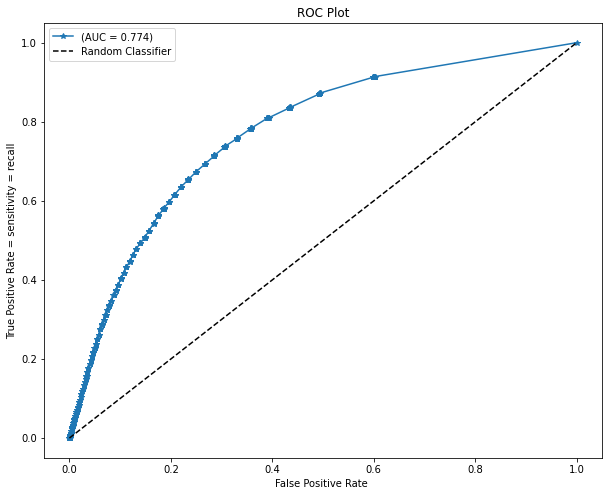

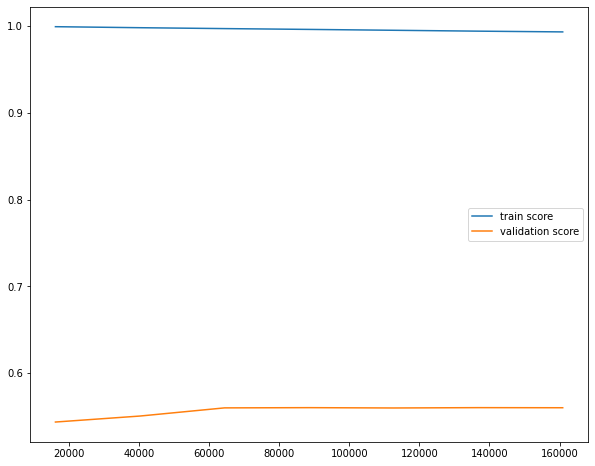

In [ ]:
auc_evaluation (rfc, X_train, y_train, X_test, y_test, True, True)

The following graph is plot fitting a RandomForest (thus without undersampling and basic parameters).

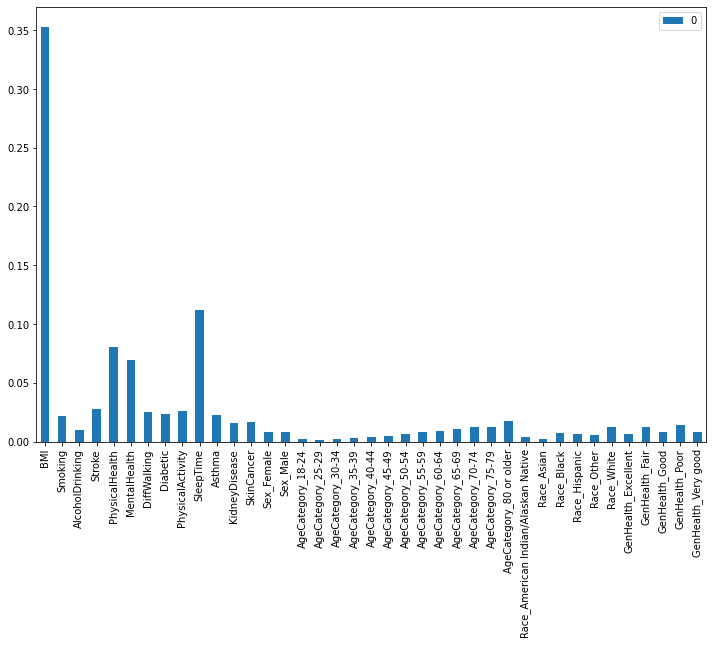

In [ ]:
pd.DataFrame ( rfc.feature_importances_, index = X_train.columns).plot.bar(figsize=(12,8));

As seen during EDA, a lot of importance is given to our numerical data. 

*Question : Should we get rid of some of those features ?*

*1. It is true that some features, especially for the youngest part of the population, seem less relevant. Nonetheless, all importances score ranges in the same values,*

*2. It doesn't appear into this report later but I tried, putting into a pipeline SelectKBest before fitting classifiers, to see the number of features to get the best score. Result: I had always to take them all for the best scores.*

## Oversampling, Undersampling or Class Weighting ? 

As we have umbalanced classes, we will various way to tackle this 'issue': 
1. Using Class Weighting, putting more weight to the positive class, 
2. Using Undersampling techniques, 
3. Using OverSampling techniques. 

### Class Weighting

To compare the following technique to tackle umbalanced classes, we will use XGBOOST.

In [ ]:
from sklearn.pipeline import make_pipeline
import xgboost as xgb

from sklearn.feature_selection import SelectKBest
from sklearn.metrics import recall_score, f1_score

from tqdm import tqdm 

First, let's see the result without any weighting : 

Confusion Matrix : 
[[54614   278]
 [ 5073   379]]


Classification Report : 
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     54892
           1       0.58      0.07      0.12      5452

    accuracy                           0.91     60344
   macro avg       0.75      0.53      0.54     60344
weighted avg       0.88      0.91      0.88     60344



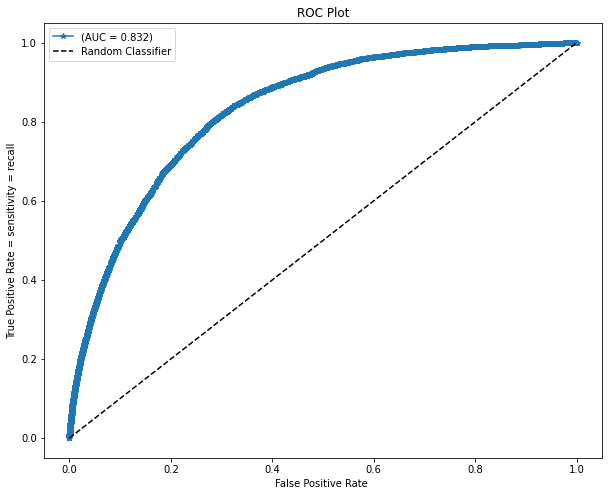

In [ ]:
xgb_clf_not_weighted = xgb.XGBClassifier(random_state=0, verbosity=0,silent = True )
auc_evaluation(xgb_clf_not_weighted,X_train, y_train,X_test, y_test, True)

Once again, the recall for the predicted class is pretty (pretty) low :7%... 

According to the docs, we need to put the parameter scale_pos_weight as


$$ \frac{Number\:of\:negative\:items}{Number\:of\:positive\:items}$$

In [ ]:
len(df[df.HeartDisease=="No"])/len(df[df.HeartDisease=="Yes"])

10.067715784453982

Confusion Matrix : 
[[40350 14542]
 [ 1209  4243]]


Classification Report : 
              precision    recall  f1-score   support

           0       0.97      0.74      0.84     54892
           1       0.23      0.78      0.35      5452

    accuracy                           0.74     60344
   macro avg       0.60      0.76      0.59     60344
weighted avg       0.90      0.74      0.79     60344



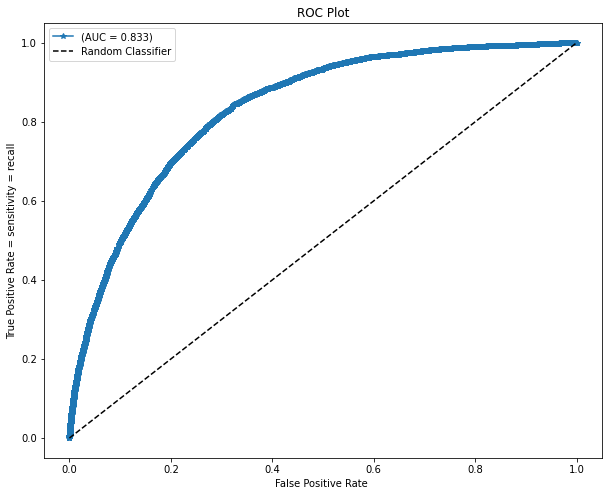

In [ ]:
xgb_clf_weighted = xgb.XGBClassifier(random_state=0, verbosity=0,silent = True,scale_pos_weight = 10 )
auc_evaluation(xgb_clf_weighted,X_train, y_train,X_test,y_test, True)

78% for the recall is great. Let's see what sampling techniques have in store. 

### Undersampling

Here, we don't give a bigger weight to class 1, but we undersample the most frequent class.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from collections import Counter

In [ ]:
xgb_clf = xgb.XGBClassifier(random_state=0, verbosity=0,silent = True )

#### Random Under Sampling

In [ ]:
# Randomly under sample the majority class
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus= rus.fit_resample(X_train, y_train)
# Check the number of records after under sampling
print(sorted(Counter(y_train_rus).items()))

[(0, 21809), (1, 21809)]


Confusion Matrix : 
[[39829 15063]
 [ 1144  4308]]


Classification Report : 
              precision    recall  f1-score   support

           0       0.97      0.73      0.83     54892
           1       0.22      0.79      0.35      5452

    accuracy                           0.73     60344
   macro avg       0.60      0.76      0.59     60344
weighted avg       0.90      0.73      0.79     60344



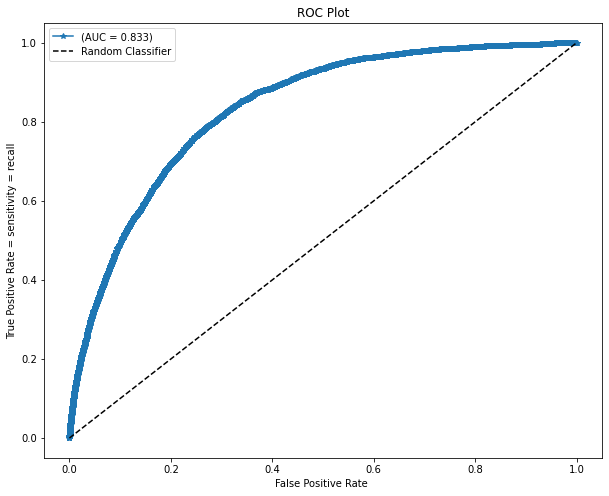

In [ ]:
auc_evaluation(xgb_clf,X_train_rus, y_train_rus,X_test, y_test, True)

79%, not bad! 

#### NearMiss

In [ ]:
#Randomly under sample the majority class
nm = NearMiss(version=3)
X_train_nm, y_train_nm= nm.fit_resample(X_train, y_train)
# Check the number of records after under sampling
print(sorted(Counter(y_train_nm).items()))

[(0, 21809), (1, 21809)]


Confusion Matrix : 
[[28424 26468]
 [ 1809  3643]]


Classification Report : 
              precision    recall  f1-score   support

           0       0.94      0.52      0.67     54892
           1       0.12      0.67      0.20      5452

    accuracy                           0.53     60344
   macro avg       0.53      0.59      0.44     60344
weighted avg       0.87      0.53      0.63     60344



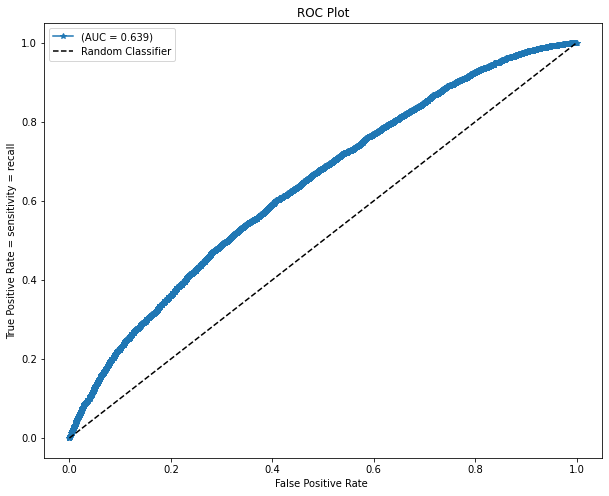

In [ ]:
auc_evaluation(xgb_clf,X_train_nm, y_train_nm,X_test, y_test, True)

67%, not as high as previous methods.

### Oversampling

Let's oversample. 

In [ ]:
from imblearn.over_sampling import RandomOverSampler

#### Random Over Sampling

In [ ]:
# Randomly over sample the minority class
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros= ros.fit_resample(X_train, y_train)
# Check the number of records after over sampling
print(sorted(Counter(y_train_ros).items()))

[(0, 219564), (1, 219564)]


Confusion Matrix : 
[[40193 14699]
 [ 1188  4264]]


Classification Report : 
              precision    recall  f1-score   support

           0       0.97      0.73      0.83     54892
           1       0.22      0.78      0.35      5452

    accuracy                           0.74     60344
   macro avg       0.60      0.76      0.59     60344
weighted avg       0.90      0.74      0.79     60344



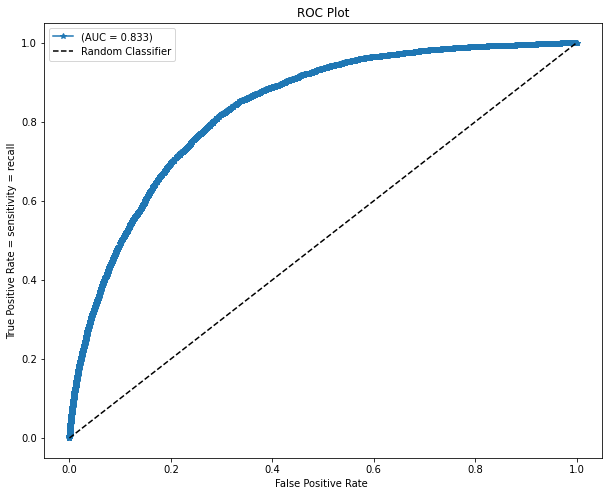

In [ ]:
auc_evaluation(xgb_clf,X_train_ros, y_train_ros, X_test, y_test,True)

#### SMOTE Oversampling

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
# Randomly over sample the minority class
smote = SMOTE(random_state=42,k_neighbors=2000)
X_train_smote, y_train_smote= smote.fit_resample(X_train, y_train)
# Check the number of records after over sampling
print(sorted(Counter(y_train_smote).items()))

[(0, 219564), (1, 219564)]


Confusion Matrix : 
[[47982  6910]
 [ 2698  2754]]


Classification Report : 
              precision    recall  f1-score   support

           0       0.95      0.87      0.91     54892
           1       0.28      0.51      0.36      5452

    accuracy                           0.84     60344
   macro avg       0.62      0.69      0.64     60344
weighted avg       0.89      0.84      0.86     60344



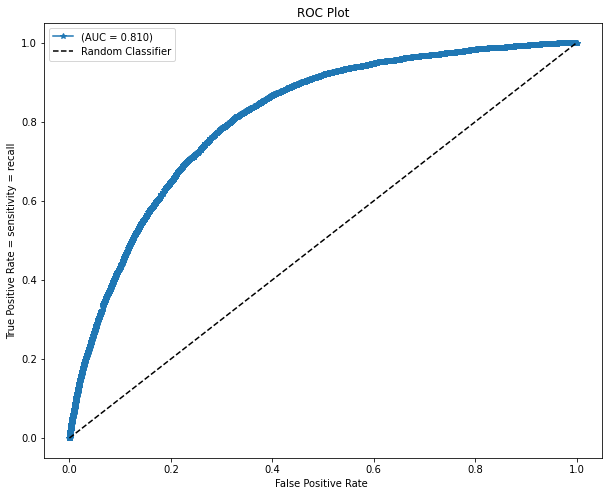

In [ ]:
auc_evaluation(xgb_clf,X_train_smote, y_train_smote, X_test, y_test,True)

**Conclusion** : 
Both Random Under and Oversampling present great results (around 78%). 

Nonetheless, undersampling might be dangerous because we delete some crucial information, and oversampling can lead to a bigger computing time. 
So , we will use a classic OG class weighting. 

# Machine Learning Models

## Model Benchmark

Let's benchmark the model , focusing on those that all class weighting. 

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 13.7 MB/s eta 0:00:00


In [ ]:
import xgboost as xgb
from catboost import CatBoostClassifier

from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,BaggingClassifier,AdaBoostClassifier 

from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.linear_model import SGDClassifier

from sklearn.tree import DecisionTreeClassifier

Hop a little Decision Tree Classifier as a base estimator : 

In [ ]:
dt = DecisionTreeClassifier(random_state=0)

In [ ]:
xgb_clf = xgb.XGBClassifier(random_state = 0, scale_pos_weight = 10,verbosity = 0, silent = True)

gb_clf = GradientBoostingClassifier(random_state=0) # no class weight

rf_clf = RandomForestClassifier(random_state = 0, class_weight='balanced')
rf_bs_clf = RandomForestClassifier(random_state = 0, class_weight='balanced_subsample')#Random Forest With Bootstrap Class Weighting
us_rf_clf = BalancedRandomForestClassifier(random_state = 0) #Random Forest With Random Undersampling

ctb_clf = CatBoostClassifier(random_state = 0,class_weights = [0.1,0.9], silent = True)

ada_clf = AdaBoostClassifier(random_state = 0,base_estimator = dt) # no class weight


We put all our classifiers into a dictionary, to loop the auc function over them :

In [ ]:
dict_of_models = {'XGBOOST' : xgb_clf, 
                  'GradientBoosting' : gb_clf, 
                  'CatBoost' : ctb_clf,
                  'RF' : rf_clf,
                  'RF bootstraping':rf_bs_clf,
                  'UnderSampling RF ':us_rf_clf,
                  'ADA' : ada_clf}

XGBOOST
Confusion Matrix : 
[[40350 14542]
 [ 1209  4243]]


Classification Report : 
              precision    recall  f1-score   support

           0       0.97      0.74      0.84     54892
           1       0.23      0.78      0.35      5452

    accuracy                           0.74     60344
   macro avg       0.60      0.76      0.59     60344
weighted avg       0.90      0.74      0.79     60344



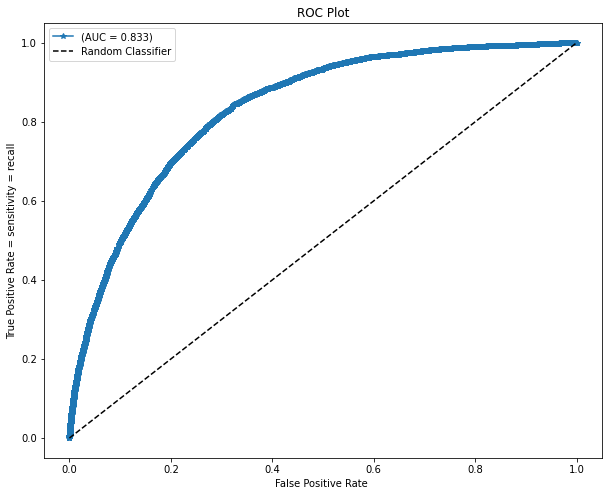

GradientBoosting
Confusion Matrix : 
[[54470   422]
 [ 4931   521]]


Classification Report : 
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     54892
           1       0.55      0.10      0.16      5452

    accuracy                           0.91     60344
   macro avg       0.73      0.54      0.56     60344
weighted avg       0.88      0.91      0.88     60344



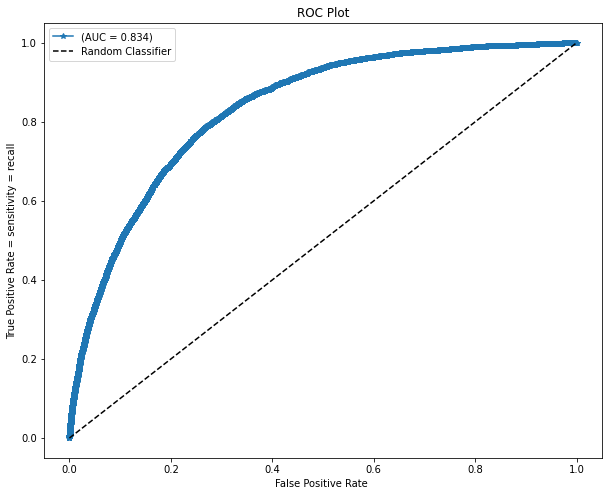

CatBoost
Confusion Matrix : 
[[42105 12787]
 [ 1456  3996]]


Classification Report : 
              precision    recall  f1-score   support

           0       0.97      0.77      0.86     54892
           1       0.24      0.73      0.36      5452

    accuracy                           0.76     60344
   macro avg       0.60      0.75      0.61     60344
weighted avg       0.90      0.76      0.81     60344



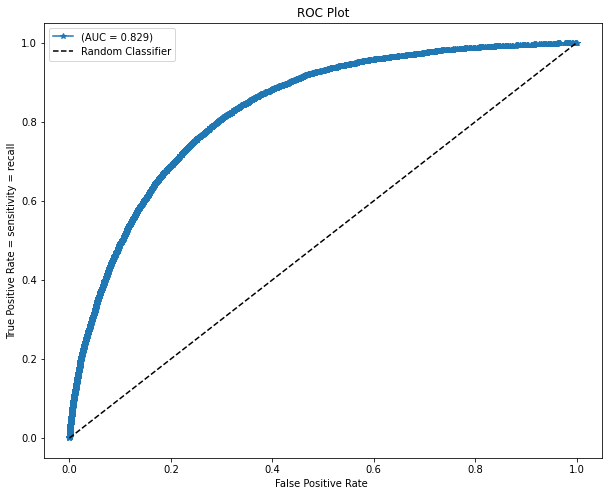

RF
Confusion Matrix : 
[[53419  1473]
 [ 4822   630]]


Classification Report : 
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     54892
           1       0.30      0.12      0.17      5452

    accuracy                           0.90     60344
   macro avg       0.61      0.54      0.56     60344
weighted avg       0.86      0.90      0.87     60344



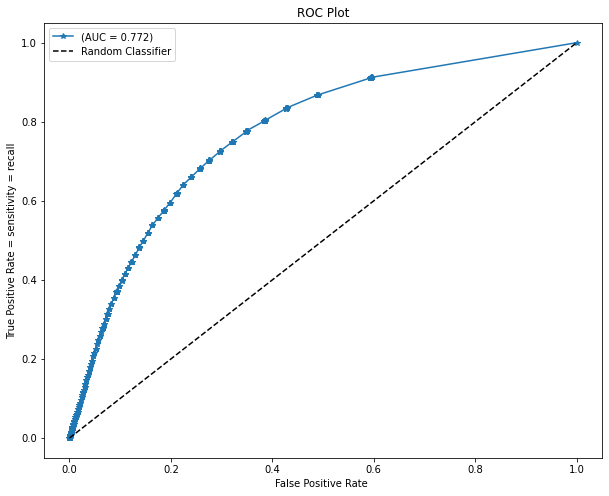

RF bootstraping
Confusion Matrix : 
[[53429  1463]
 [ 4814   638]]


Classification Report : 
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     54892
           1       0.30      0.12      0.17      5452

    accuracy                           0.90     60344
   macro avg       0.61      0.55      0.56     60344
weighted avg       0.86      0.90      0.87     60344



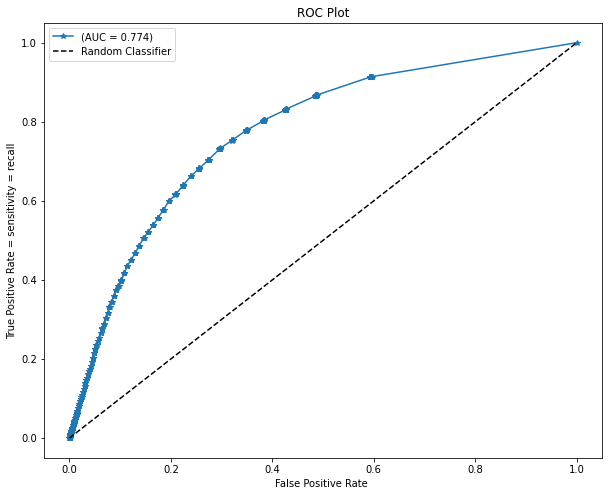

UnderSampling RF 
Confusion Matrix : 
[[38624 16268]
 [ 1171  4281]]


Classification Report : 
              precision    recall  f1-score   support

           0       0.97      0.70      0.82     54892
           1       0.21      0.79      0.33      5452

    accuracy                           0.71     60344
   macro avg       0.59      0.74      0.57     60344
weighted avg       0.90      0.71      0.77     60344



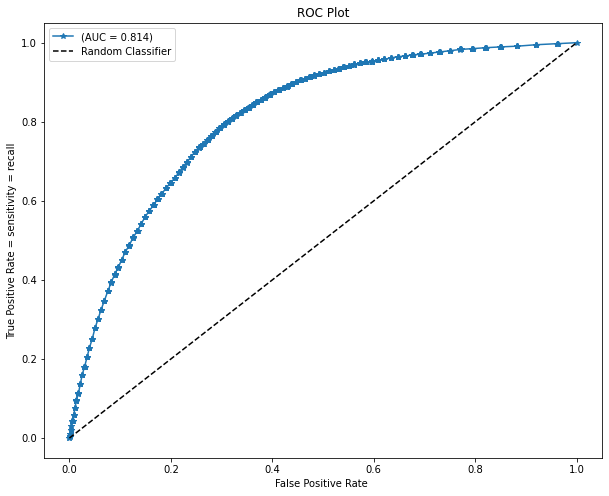

ADA
Confusion Matrix : 
[[51791  3101]
 [ 4307  1145]]


Classification Report : 
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     54892
           1       0.27      0.21      0.24      5452

    accuracy                           0.88     60344
   macro avg       0.60      0.58      0.58     60344
weighted avg       0.86      0.88      0.87     60344



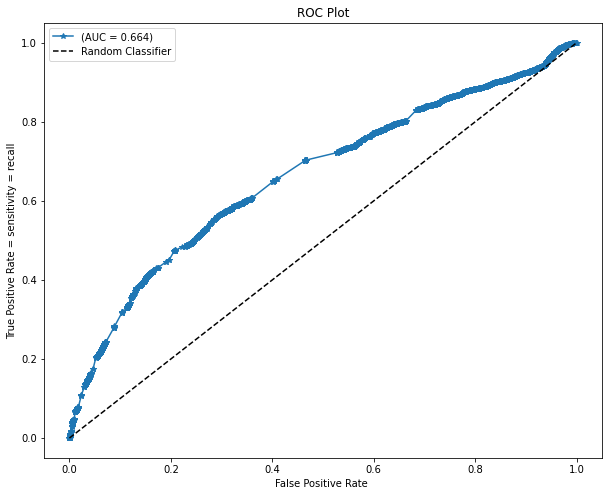

In [ ]:
for name, model in dict_of_models.items() : 
    print(name)
    auc_evaluation(model,X_train, y_train ,X_test, y_test, True)

The most promising is **XGBoost**.

## Randomized GridSearchCV

We left the code into comments to avoid the long GridSearch output lines. 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
xgb_clf = xgb.XGBClassifier(random_state = 0, scale_pos_weight = 10.7,verbosity = 1, silent = False, tree_method='gpu_hist')

In [ ]:
#Hyperparameters to test
params = {    
        'max_depth': np.arange(2, 11, 1), 
        'n_estimators' : np.arange(10, 500, 10), 
        'learning_rate' : np.arange(0.01, 1, 0.01)
        }

In [ ]:
#random_search = RandomizedSearchCV(
#   estimator=xgb_clf,
#   param_distributions=params,
#   n_iter=100,
#   cv=3,
#   scoring="recall",
#   random_state=42, 
#   verbose = 5)
#   #n_jobs = -1

In [ ]:
#random_search.fit(X_train, y_train)

In [ ]:
#random_search.best_params_

In [ ]:
#auc_evaluation(random_search.best_estimator_,X_train,y_train,X_test,y_test,True)

## Grid search CV

Now that we have a range of the best parameters, let's focus near them. 

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
params = {    
        'max_depth': [4,5,6,7,8,9,19], 
        'n_estimators' : [7,8,9,10,11,12,14,18,20], 
        'learning_rate' : [0.01, 0.03, 0.07, 0.1, 0.3, 0.7]
        }

In [ ]:
grid_search = GridSearchCV(xgb_clf, 
                params, 
                cv=3, 
                scoring="recall",
                verbose=3)
                #n_jobs=-1)

In [ ]:
#grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 20}

The best parameters are : 

```
{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 20}
```



Confusion Matrix : 
[[38434 16458]
 [ 1003  4449]]


Classification Report : 
              precision    recall  f1-score   support

           0       0.97      0.70      0.81     54892
           1       0.21      0.82      0.34      5452

    accuracy                           0.71     60344
   macro avg       0.59      0.76      0.58     60344
weighted avg       0.91      0.71      0.77     60344



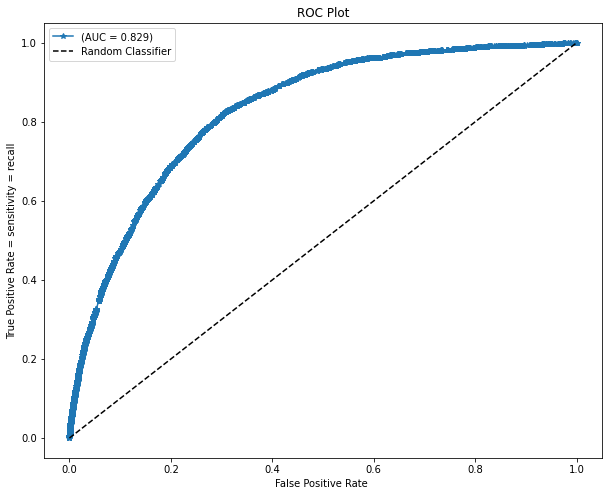

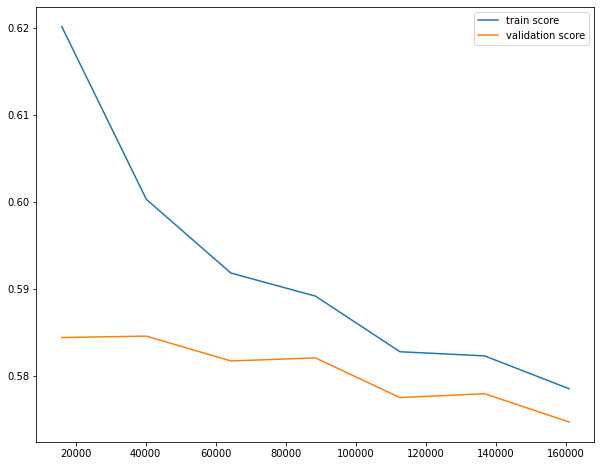

In [ ]:
auc_evaluation(grid_search.best_estimator_,X_train,y_train,X_test,y_test,True,True)

The general score is decreasing, but at least we are not in overfitting. 

## Conclusion of Machine Learning Models

These are the steps we encoutered : 
- A basic random forest classifier gave us a pretty low recall score for the positive class, 
- With class weighting, XGBOOST without tuning gave us a recall of 78%, and f1 scores of 84 and 35%. 
- A tuned XGBOOST gives us a recall of 82%. 

# NN with Keras

In [3]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
import math
from tensorflow.keras.layers import StringLookup

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler,OneHotEncoder, StandardScaler,MinMaxScaler, OrdinalEncoder

In [48]:
from sklearn.metrics import confusion_matrix, precision_recall_curve,roc_curve,accuracy_score,classification_report,ConfusionMatrixDisplay

In [5]:
target_label="HeartDisease"
categorical_yesno= ['Smoking', 'AlcoholDrinking', 'Stroke',
                    'DiffWalking', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer', 'Diabetic' 
                    ]
# categorical_features = ['Sex','AgeCategory', 'Race' ,'GenHealth']   
categorical_features = ['Sex','AgeCategory' ,'GenHealth']  
numerical_features =['BMI','PhysicalHealth','MentalHealth', 'SleepTime']     

age_category_order =  ['80 or older', '75-79','70-74','65-69', '60-64','55-59','50-54',
 '45-49' ,'40-44' , '35-39','30-34','25-29','18-24']
keep_columns= categorical_yesno + categorical_features+numerical_features     

In [6]:
def mypreprocessor_separated(df,keep_columns,dataType = "train", 
            encoders = None, params = {"numScaler" : RobustScaler(), "HotEncodeYesNo": True}):
    y= df[target_label]
    
    if(params["HotEncodeYesNo"]):
        X_categorical = df[categorical_features + categorical_yesno]
        X_yesno = None
    else:
        X_categorical = df[categorical_features]
        X_yesno = df[categorical_yesno]
    X_numerical = df[numerical_features]
    
    # Some imputer if needed
    
    # Some outlier processing if needed

    encoded_yesNo_df = None
    if(dataType =="train"):
        #Normalize numerical data
        encoderNumerical = params["numScaler"]
        X_numerical =pd.DataFrame(encoderNumerical.fit_transform(X_numerical), columns=encoderNumerical.get_feature_names_out())
        
        #Hot Encoding of categorical and yes/no features
        encoderCategorical = OneHotEncoder(sparse=False)
        onehot = encoderCategorical.fit_transform(X_categorical)
        encoded_df = pd.DataFrame(onehot, columns=encoderCategorical.get_feature_names_out())
        
        #Dummies for yesNo
        encoderYesNo = OrdinalEncoder()
        if (not X_yesno.empty):
            OrdinalEncoded = encoderYesNo.fit_transform(X_yesno)
            encoded_yesNo_df = pd.DataFrame(OrdinalEncoded, columns=encoderYesNo.get_feature_names_out())

        # Label encoder
        labelEnc = preprocessing.OrdinalEncoder(dtype=np.int32)
        labelEnc.fit(np.array(y).reshape(-1,1))
    else:
        #Normalize numerical data with passed encoder
        encoderNumerical = encoders["numEncoder"]
        X_numerical =pd.DataFrame(encoderNumerical.transform(X_numerical), columns=encoderNumerical.get_feature_names_out())
        #Hot Encoding of categorical and yes/no features with passed encoder
        encoderCategorical = encoders["catEncoder"]
        onehot = encoderCategorical.transform(X_categorical)
        encoded_df = pd.DataFrame(onehot, columns=encoderCategorical.get_feature_names_out())

        #Dummies for yesNo
        encoderYesNo = encoders["yesnoEncoder"]
        if (not X_yesno.empty):
            OrdinalEncoded = encoderYesNo.transform(X_yesno)
            encoded_yesNo_df = pd.DataFrame(OrdinalEncoded, columns=encoderYesNo.get_feature_names_out())

        labelEnc = encoders["labelEncoder"]


    # Join all data together
    X =pd.concat([X_numerical, encoded_df,encoded_yesNo_df], axis=1)
    y = pd.DataFrame(labelEnc.transform(np.array(y).reshape(-1,1)))
    return X, y, {"numEncoder": encoderNumerical, "catEncoder": encoderCategorical,"labelEncoder": labelEnc,"yesnoEncoder": encoderYesNo}

In [7]:
def preprocess_level0(df):
    # Remove duplicates
    df.drop_duplicates(inplace=True)
    return df

In [51]:
df_preprocesslevel0 = preprocess_level0(df)

In [23]:
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(df_preprocesslevel0, df_preprocesslevel0[target_label], 
                                                    test_size=0.3, stratify=df_preprocesslevel0[target_label], 
                                                    random_state=123456)

In [24]:
X_train_data.head().T

266545                   7695       62282      297432  \
HeartDisease          No                       No         No         No   
BMI                34.95                    25.75      27.46       35.3   
Smoking               No                       No         No         No   
AlcoholDrinking       No                       No         No         No   
Stroke                No                       No         No         No   
PhysicalHealth      10.0                     10.0        0.0        0.0   
MentalHealth         2.0                      5.0        0.0        3.0   
DiffWalking           No                       No         No         No   
Sex               Female                   Female     Female       Male   
AgeCategory        65-69                    70-74      75-79      40-44   
Race               White                    White   Hispanic      White   
Diabetic              No  No, borderline diabetes         No         No   
PhysicalActivity      No                       No        Yes        Yes   
GenHealth           Fair                     Fair  Excellent  Very good   
SleepTime            9.0                      7.0        7.0        7.0   
Asthma               Yes                       No         No         No   
KidneyDisease         No                       No         No         No   
SkinCancer            No                       No         No         No   

                  49597   
HeartDisease          No  
BMI                19.49  
Smoking              Yes  
AlcoholDrinking       No  
Stroke                No  
PhysicalHealth       0.0  
MentalHealth         0.0  
DiffWalking           No  
Sex               Female  
AgeCategory        55-59  
Race               White  
Diabetic              No  
PhysicalActivity     Yes  
GenHealth           Fair  
SleepTime           10.0  
Asthma               Yes  
KidneyDisease         No  
SkinCancer            No

In [25]:
params = {"numScaler": MinMaxScaler(),"HotEncodeYesNo": False}
X_train, y_train, encoders = mypreprocessor_separated(X_train_data,keep_columns,dataType="train", params=params)

In [26]:
X_test, y_test, encoders = mypreprocessor_separated(X_test_data,keep_columns,dataType="test", 
    encoders = encoders,params=params) 

In [27]:
X_test.shape

(90516, 33)

In [28]:
def createNN2(input_shape):
    model = keras.Sequential(
    [
        keras.Input(shape=(input_shape,)),
        keras.layers.Dense(
            352, activation="relu")
        ,
        keras.layers.Dropout(0.3),
        keras.layers.Dense(352, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(192, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(352, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(352, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
    )
    return model

In [41]:
TARGET_LABELS = ["Yes", "No"]
num_classes = len(TARGET_LABELS)
learning_rate = 0.01
batch_size = 416
num_epochs = 10
loss = "binary_crossentropy"
optimizer = "nadam"
weight= 2.2
optimizers_list = {"adam": tf.keras.optimizers.Adam(learning_rate),
                      "adamW": tf.keras.optimizers.experimental.AdamW(learning_rate),
                        "rmspro": tf.keras.optimizers.RMSprop(learning_rate),
                        "nadam": tf.keras.optimizers.Nadam(learning_rate),
        }
shuffle=True

model= createNN2(X_train.shape[-1])
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.Recall(name="auc"),
]
model.compile(
    optimizer=optimizers_list[optimizer], loss=loss, metrics=metrics
)
callbacks = [keras.callbacks.ModelCheckpoint("model_test_nn_{epoch}.h5")]
weight_for_0 = 1.0 / y_train[y_train[0] == 0].count()
weight_for_1 = (1.0 / y_train[y_train[0] == 1].count())*weight
class_weight = {0: weight_for_0, 1: weight_for_1}

In [43]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 352)               11968     
                                                                 
 dropout_10 (Dropout)        (None, 352)               0         
                                                                 
 dense_13 (Dense)            (None, 352)               124256    
                                                                 
 dropout_11 (Dropout)        (None, 352)               0         
                                                                 
 dense_14 (Dense)            (None, 192)               67776     
                                                                 
 dropout_12 (Dropout)        (None, 192)               0         
                                                                 
 dense_15 (Dense)            (None, 352)              

In [44]:
model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    verbose=2,
    validation_data=(X_test, y_test),
    class_weight=class_weight,
    shuffle=shuffle,
    use_multiprocessing=True,
)

Epoch 1/10
508/508 - 11s - loss: 7.1085e-06 - fn: 1571.0000 - fp: 93831.0000 - tn: 98287.0000 - tp: 17512.0000 - precision: 0.1573 - recall: 0.9177 - auc: 0.9177 - val_loss: 0.6523 - val_fn: 932.0000 - val_fp: 31999.0000 - val_tn: 50339.0000 - val_tp: 7246.0000 - val_precision: 0.1846 - val_recall: 0.8860 - val_auc: 0.8860 - 11s/epoch - 21ms/step
Epoch 2/10
508/508 - 8s - loss: 6.9082e-06 - fn: 1503.0000 - fp: 88946.0000 - tn: 103172.0000 - tp: 17580.0000 - precision: 0.1650 - recall: 0.9212 - auc: 0.9212 - val_loss: 0.7107 - val_fn: 796.0000 - val_fp: 33815.0000 - val_tn: 48523.0000 - val_tp: 7382.0000 - val_precision: 0.1792 - val_recall: 0.9027 - val_auc: 0.9027 - 8s/epoch - 16ms/step
Epoch 3/10
508/508 - 8s - loss: 6.8681e-06 - fn: 1561.0000 - fp: 87048.0000 - tn: 105070.0000 - tp: 17522.0000 - precision: 0.1676 - recall: 0.9182 - auc: 0.9182 - val_loss: 0.6440 - val_fn: 931.0000 - val_fp: 31640.0000 - val_tn: 50698.0000 - val_tp: 7247.0000 - val_precision: 0.1864 - val_recall: 0.8

In [45]:
Y_pred = model.predict(X_test)
y_pred = np.round(Y_pred, 0)

2829/2829 [==============================] - 6s 2ms/step


In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.55      0.70     82338
           1       0.17      0.92      0.28      8178

    accuracy                           0.58     90516
   macro avg       0.58      0.73      0.49     90516
weighted avg       0.91      0.58      0.67     90516



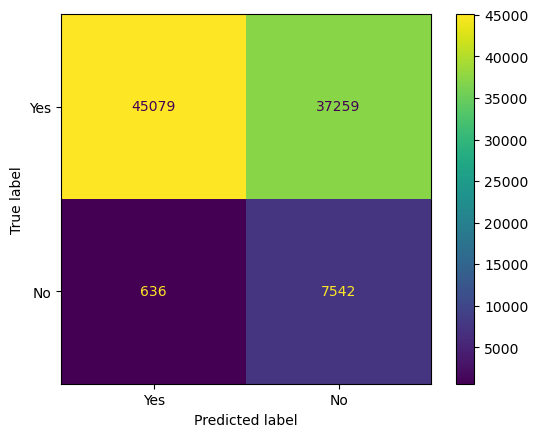

In [49]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=TARGET_LABELS)
disp.plot()
plt.show()

# Sources 

https://medium.com/grabngoinfo/four-oversampling-and-under-sampling-methods-for-imbalanced-classification-using-python-7304aedf9037
https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/